Code is based on https://github.com/jhuggins/viabel

In [1]:
import pickle
import pystan
import autograd.numpy as np

from viabel.objectives import (black_box_klvi,
                               black_box_chivi)

from viabel.family import (mean_field_gaussian_variational_family,
                           mean_field_t_variational_family,
                           t_variational_family)

from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import (plot_dist_to_opt_param,
                         check_approx_accuracy,
                         psis_correction)

import pandas as pd
import time
from autograd.scipy.stats import norm
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define the model

In [2]:
test_model = """data {
  int<lower=0> N;   // number of observations
  int <lower=0> D;  // number of predictors
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}

parameters {
  vector[D] beta;        // coefficients for predictors
  real <lower=0> sigma;  // variance
}

model {
   beta ~ normal(0,1);
   sigma ~ gamma(0.5,0.5);
   y ~ normal(x * beta, sigma);
}"""

Generate or open existing a pkl file of the model

In [3]:
compiled_model_file = 'blr_reg_model.pkl'

try:
    with open(compiled_model_file, 'rb') as f:
        regression_model = pickle.load(f)
except:
    regression_model = pystan.StanModel(model_code=test_model,
                                        model_name='regression_model')
    with open('blr_reg_model.pkl', 'wb') as f:
        pickle.dump(regression_model, f)

Get data

In [4]:
# SYNTHETIC
# np.random.seed(1234)

# N = 1000
# D = 10
# beta_gen = np.random.randn(D, 1)
# sigma_gen = np.random.gamma(1, 1, 1)

# x = np.random.randn(N, D)
# y_raw = x.dot(beta_gen) + np.random.randn(N, 1)*np.sqrt(sigma_gen)
# y = y_raw - np.mean(y_raw)
# # convert from Nx1 matrix to Nx1 vector
# y = y.flatten()

In [5]:
#print(beta_gen)

In [6]:
#print(sigma_gen)

Import the dataset

In [7]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()
data.head(3)

,Bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,-6.850794,-21.884921,-24.674405,-2.39881,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-13.050794,-22.884921,-5.674405,2.10119,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,6.149206,-22.884921,-24.924405,-3.89881,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762


In [8]:
y = data["Bodyfat"].values
# centre the response to adjust for no intercept
y = y - np.mean(y)

x = data.drop("Bodyfat", axis=1)

N = x.shape[0]
D = x.shape[1]

First, generate ground-truth posterior samples using Stan's dynamic HMC implementation:

In [9]:
data = dict(N=N, D=D, x=x, y=y)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=10)

In [10]:
true_beta_mean = np.mean(fit['beta'], axis=0)
true_beta_cov = np.cov(fit['beta'].T)
print('true beta mean =', true_beta_mean)
print('true beta cov =', true_beta_cov)

true beta mean = [ 0.05458021 -0.09350057 -0.07786804 -0.49183548 -0.01572817  0.95423469
 -0.20385013  0.23715451  0.00709636  0.13444597  0.17672052  0.4087033
 -1.26645611]
true beta cov = [[ 1.01403775e-03  3.17485254e-04  4.01492199e-04 -6.80701440e-04
  -1.06199195e-04 -1.19966345e-03  4.51525362e-04  1.60709919e-03
  -1.79178634e-03  4.63817452e-04 -4.27782722e-04  1.06127081e-03
  -4.82846876e-03]
 [ 3.17485254e-04  2.80485484e-03 -2.31752220e-03 -3.36643464e-03
  -2.24999635e-03 -8.45255672e-04 -4.12987636e-03 -6.95659217e-04
  -3.17659525e-03 -1.94063990e-03 -1.58334286e-03  1.36014736e-04
  -3.39273699e-03]
 [ 4.01492199e-04 -2.31752220e-03  9.00808461e-03  3.86578588e-04
   2.04009509e-03  8.83296200e-04  3.34596679e-03  2.90522353e-03
  -1.54892047e-03  4.83797552e-04  9.92261539e-04  3.95083040e-04
  -3.88490518e-03]
 [-6.80701440e-04 -3.36643464e-03  3.86578588e-04  4.96257735e-02
  -1.48417620e-03 -2.14582401e-04  5.40650319e-03 -2.59231636e-03
   7.30745388e-03  3.8984

In [11]:
true_sigma_mean = np.mean(fit['sigma'], axis=0)
true_sigma_cov = np.cov(fit['sigma'].T)
print('true sigma mean =', true_sigma_mean)
print('true sigma cov =', true_sigma_cov)

true sigma mean = 4.294554049520795
true sigma cov = 0.040765449383006164


In [12]:
vec1 = fit['beta']
vec2 = np.array(fit['sigma'])
vec = []
for i in range(len(vec1)):
    temp = list(np.append(vec1[i], vec2[i]))
    vec.append(temp)
vec = np.array(vec)

In [13]:
true_mean = np.mean(vec, axis=0)
true_cov = np.cov(vec.T)

In [14]:
#print('true mean =', true_mean)
#print('true cov =', true_cov)

In [15]:
fit

Inference for Stan model: regression_model_b1ab85b6e8abedc0878d3fa66ea1be75.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    0.05  4.8e-4   0.03 -8.1e-3    0.03   0.05   0.08   0.12   4458    1.0
beta[2]   -0.09  7.5e-4   0.05    -0.2   -0.13  -0.09  -0.06   0.01   5043    1.0
beta[3]   -0.08  1.4e-3   0.09   -0.26   -0.14  -0.08  -0.01   0.11   4780    1.0
beta[4]   -0.49  3.1e-3   0.22   -0.92   -0.64  -0.49  -0.34  -0.05   5138    1.0
beta[5]   -0.02  1.4e-3    0.1   -0.21   -0.08  -0.02   0.05   0.18   4776    1.0
beta[6]    0.95  1.2e-3   0.09    0.79     0.9   0.95   1.01   1.12   5034    1.0
beta[7]    -0.2  2.1e-3   0.15   -0.49    -0.3   -0.2  -0.11   0.09   5007    1.0
beta[8]    0.24  2.0e-3   0.14   -0.04    0.14   0.24   0.33   0.52   5179    1.0
beta[9]  7.1e-3  3.2e-3   0.23   -0.45   -0.15 8.4e-3   0.17   0

# KLVI

## Mean field with Gaussian

In [16]:
# def logjointpdf(samples, x=x, y=y, D=D):
#     beta, log_sigma = samples[:, 0:D], samples[:, D]
#     mu = np.dot(x, np.transpose(beta))
    
#     lpdf = np.zeros(len(samples))

#     print("I'm here")
#     print(norm.logpdf(0,1,np.exp(log_sigma[0])))
#     for i in range(len(samples)):
#         p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#         p2 = gamma.logpdf(np.exp(log_sigma[i]), .5, loc=0, scale=.5)
#         p3 = sum(norm.logpdf(beta[i,:], 0, 1))
                 
#         lpdf[i] = p1 + p2 + p3
     
#     return lpdf

In [17]:
# def logjointpdf(samples, x=x, y=y, D=D):
#     beta, log_sigma = samples[:, 0:D], samples[:, D]
#     mu = np.dot(x, np.transpose(beta))    
#     lpdf = []
    
#     a = .5
#     b = .5
#     for i in range(len(samples)):
#         p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#         z = np.exp(log_sigma[i])
#         p2 = -np.log(gamma(a)) - a*np.log(b) + (a-1)*np.log(z) - z/b
#         p3 = sum(norm.logpdf(beta[i,:], 0, 1))
                 
#         lpdf.append(p1 + p2 + p3)

#     return np.array(lpdf)

In [18]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)

init_mean = np.zeros(D+1)
init_log_std = np.ones(D+1)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 2000

In [19]:
stan_log_density = make_stan_log_density(fit)

In [20]:
klvi_objective_and_grad = black_box_klvi(mf_gaussian_var_family, stan_log_density, 100)

klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=1e-2)

Average Loss = 588.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.78it/s]


In [21]:
#plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

In [22]:
check_approx_accuracy(mf_gaussian_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 5.44384297e-02 -1.02126322e-01 -7.30403373e-02 -4.85712732e-01
 -3.41180830e-04  9.40875347e-01 -1.69420817e-01  2.37305100e-01
  2.21088054e-03  1.18992872e-01  1.69170660e-01  3.99143009e-01
 -1.17513989e+00  1.50436742e+00]
stdevs = [0.03112333 0.02675642 0.07930115 0.13354185 0.05161203 0.04486748
 0.05941958 0.07102985 0.13597238 0.17690945 0.11087364 0.15093563
 0.30545673 0.04822361]

mean error             = 2.79
stdev error            = 0.302
||cov error||_2^{1/2}  = 0.377
||true cov||_2^{1/2}   = 0.479


In [23]:
mc_samples = 100000

samples, smoothed log weights, khat

In [24]:
klvi_samples, klvi_slw, klvi_lw, klvi_khat = \
    psis_correction(stan_log_density, mf_gaussian_var_family, klvi_var_param, mc_samples)

In [25]:
print(klvi_khat)

0.9336263340218836


In [26]:
klvi_slw

array([-22.14364824, -42.29143453, -22.04874729, ..., -22.11146712,
       -23.7798717 , -23.32283541])

In [27]:
klvi_lw

array([-520.51275698, -540.66054327, -520.41785603, ..., -520.48057586,
       -522.14898044, -521.69194415])

### VSBC diagnostics

In [28]:
# with open("./data/klvi_psis_"+str(99)+".pkl", 'rb') as f:
#     [btemp, stemp, klvi_samples_temp, klvi_slw_temp, klvi_lw_temp, klvi_khat_temp, klvi_var_param] = pickle.load(f)

In [29]:
#     def logjointpdf(samples, x=xtemp, y=y, D=D):
#         beta, log_sigma = samples[:, 0:D], samples[:, D]
#         mu = np.dot(x, np.transpose(beta))

#         lpdf = np.zeros(len(samples))
#         for i in range(len(samples)):
#             p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#             p2 = gamma.logpdf(np.exp(log_sigma[i]), .5, 0, .5)
#             p3 = sum(norm.logpdf(beta[i,:], 0, 1))

#             lpdf[i] = p1 + p2 + p3

#         return lpdf
    
    # initialise klvi
#     def logjointpdf(x, data=xtemp, y=ytemp, D=D):
#         beta, log_sigma = x[:, 0:D], x[:, D]
#         mu = np.dot(x.values, np.transpose(beta))
        
#         obs_density = norm.logpdf(y, mu, np.exp(log_sigma))
#         sigma_density = gamma.logpdf(np.exp(log_sigma), .5, 0, .5)
#         beta_density = norm.logpdf(beta, 0, 1)
        
#         return sum(obs_density)+sum(beta_density)+sigma_density

In [30]:
M = 100
klvi_probs = np.zeros(shape=(D+1, M))

#np.random.seed(12345)
np.random.seed(100)

In [31]:
start = time.time()
for i in range(M):
    start_loop = time.time()
    
    # sample from prior
    btemp = np.random.randn(1, D)
    mtemp = np.dot(x.values, np.transpose(btemp))
    stemp = np.random.gamma(.5, .5, 1)
    ytemp = mtemp + stemp
    
    datatemp = dict(N=N, D=D, x=x, y=y)
    fittemp = regression_model.sampling(data=datatemp, iter=20000, thin=20, chains=10)
    stan_log_density_temp = make_stan_log_density(fittemp)
    
    klvi_objective_and_grad_temp = black_box_klvi(mf_gaussian_var_family, stan_log_density_temp, 100)
    
    # run klvi
    klvi_temp_var_param, _, _, _ = \
        adagrad_optimize(n_iters, klvi_objective_and_grad_temp, init_var_param, learning_rate=.01)
    
    # store files for later
    klvi_samples_temp, klvi_slw_temp, klvi_lw_temp, klvi_khat_temp = \
        psis_correction(stan_log_density, mf_gaussian_var_family, klvi_var_param, mc_samples)
    
    with open("./data/klvi_psis_"+str(i)+".pkl", 'wb') as f:
        pickle.dump([btemp, stemp, klvi_samples_temp, klvi_slw_temp, klvi_lw_temp, klvi_khat_temp, klvi_var_param], f)
    
    end_loop = time.time()
    print("Iteration = %i, loop time = %f, time elapsed = %f" % (i, end_loop-start_loop, end_loop-start))
    
    
    ##################################################################
    ##################################################################
    # can remove this part and do it later with the pickled data file
    
    # extract beta mean and std
    b_mean_temp = klvi_temp_var_param[:D]
    b_std_temp = np.exp(klvi_temp_var_param[D+1:][0:D])

    # generate 1000 sample from the variational family
    nn = 1000
    sample_temp = mf_gaussian_var_family.sample(klvi_temp_var_param, nn)

    # compute log sigma of the samples
    logs_sample_temp = []
    for j in range(nn):
        logs_sample_temp.append(sample_temp[j][-1])
    logs_sample_temp = np.array(logs_sample_temp)
    logs_sample_temp = np.log(logs_sample_temp)

    # get the cdf values
    klvi_probs[0:D, i] = norm.cdf(btemp, b_mean_temp[0:D], b_std_temp[0:D])
    klvi_probs[D, i] = norm.cdf(np.log(stemp), np.mean(logs_sample_temp), np.std(logs_sample_temp))
   
    ##################################################################
    ##################################################################

end = time.time()
print("Total time taken: %f" % (end-start))

Average Loss = 608.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.03it/s]


Iteration = 0, loop time = 25.181899, time elapsed = 25.182900


Average Loss = 592.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.22it/s]


Iteration = 1, loop time = 25.556949, time elapsed = 50.746855


Average Loss = 601.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.80it/s]


Iteration = 2, loop time = 25.934610, time elapsed = 76.687471


Average Loss = 588.35: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.31it/s]


Iteration = 3, loop time = 25.019089, time elapsed = 101.712565


Average Loss = 590.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.89it/s]


Iteration = 4, loop time = 24.900137, time elapsed = 126.618708


Average Loss = 603.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.30it/s]


Iteration = 5, loop time = 25.050501, time elapsed = 151.674215


Average Loss = 596.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 215.09it/s]


Iteration = 6, loop time = 26.054914, time elapsed = 177.736135


Average Loss = 600.42: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.39it/s]


Iteration = 7, loop time = 25.990842, time elapsed = 203.732983


Average Loss = 581.05: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.03it/s]


Iteration = 8, loop time = 25.225518, time elapsed = 228.965508


Average Loss = 607.04: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.14it/s]


Iteration = 9, loop time = 25.276251, time elapsed = 254.247764


Average Loss = 621.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.22it/s]


Iteration = 10, loop time = 26.657547, time elapsed = 280.911317


Average Loss = 594.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.81it/s]


Iteration = 11, loop time = 26.696285, time elapsed = 307.614609


Average Loss = 604.98: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.19it/s]


Iteration = 12, loop time = 26.011891, time elapsed = 333.632505


Average Loss = 609.38: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.22it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration = 13, loop time = 26.573937, time elapsed = 360.211447


Average Loss = 592.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.11it/s]


Iteration = 14, loop time = 26.266802, time elapsed = 386.484253


Average Loss = 612.78: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.32it/s]


Iteration = 15, loop time = 26.662264, time elapsed = 413.151522


Average Loss = 601.56: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.06it/s]


Iteration = 16, loop time = 26.331814, time elapsed = 439.488341


Average Loss = 583.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.81it/s]


Iteration = 17, loop time = 26.846938, time elapsed = 466.341284


Average Loss = 593.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.17it/s]


Iteration = 18, loop time = 25.301436, time elapsed = 491.648725


Average Loss = 583.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.51it/s]


Iteration = 19, loop time = 26.181828, time elapsed = 517.835557


Average Loss = 590.98: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.04it/s]


Iteration = 20, loop time = 27.333564, time elapsed = 545.176128


Average Loss = 606.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 225.33it/s]


Iteration = 21, loop time = 27.358325, time elapsed = 572.542460


Average Loss = 603.24: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.11it/s]


Iteration = 22, loop time = 26.970445, time elapsed = 599.518911


Average Loss = 598.1: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.25it/s]


Iteration = 23, loop time = 26.766996, time elapsed = 626.291913


Average Loss = 608.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.86it/s]


Iteration = 24, loop time = 25.605320, time elapsed = 651.904238


Average Loss = 604.62: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 217.49it/s]


Iteration = 25, loop time = 26.204419, time elapsed = 678.114664


Average Loss = 589.09: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.37it/s]


Iteration = 26, loop time = 26.140290, time elapsed = 704.259958


Average Loss = 587.56: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.53it/s]


Iteration = 27, loop time = 26.401514, time elapsed = 730.667477


Average Loss = 597.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.16it/s]


Iteration = 28, loop time = 26.207756, time elapsed = 756.881238


Average Loss = 594.26: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.27it/s]


Iteration = 29, loop time = 25.931224, time elapsed = 782.818467


Average Loss = 596.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.08it/s]


Iteration = 30, loop time = 25.803100, time elapsed = 808.627573


Average Loss = 593.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.08it/s]


Iteration = 31, loop time = 25.247940, time elapsed = 833.881518


Average Loss = 596.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.34it/s]


Iteration = 32, loop time = 25.863590, time elapsed = 859.750112


Average Loss = 597.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.24it/s]


Iteration = 33, loop time = 25.438148, time elapsed = 885.194266


Average Loss = 600.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.20it/s]


Iteration = 34, loop time = 26.441538, time elapsed = 911.642810


Average Loss = 590.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.90it/s]


Iteration = 35, loop time = 26.349998, time elapsed = 937.999815


Average Loss = 594.29: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.62it/s]


Iteration = 36, loop time = 24.541434, time elapsed = 962.547254


Average Loss = 591.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 207.07it/s]


Iteration = 37, loop time = 26.431243, time elapsed = 988.984503


Average Loss = 593.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.01it/s]


Iteration = 38, loop time = 25.346679, time elapsed = 1014.337187


Average Loss = 613.24: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.01it/s]


Iteration = 39, loop time = 25.216919, time elapsed = 1039.560113


Average Loss = 588.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.51it/s]


Iteration = 40, loop time = 25.437111, time elapsed = 1065.004231


Average Loss = 592.1: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.08it/s]


Iteration = 41, loop time = 25.988980, time elapsed = 1090.999217


Average Loss = 589.77: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.89it/s]


Iteration = 42, loop time = 27.046584, time elapsed = 1118.051806


Average Loss = 606.81: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.78it/s]


Iteration = 43, loop time = 25.509224, time elapsed = 1143.567036


Average Loss = 601.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.04it/s]


Iteration = 44, loop time = 25.891033, time elapsed = 1169.463074


Average Loss = 596.9: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.28it/s]


Iteration = 45, loop time = 25.119835, time elapsed = 1194.588914


Average Loss = 601.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.78it/s]


Iteration = 46, loop time = 25.830342, time elapsed = 1220.425261


Average Loss = 597.1: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.31it/s]


Iteration = 47, loop time = 25.736083, time elapsed = 1246.167350


Average Loss = 598.75: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.14it/s]


Iteration = 48, loop time = 25.269104, time elapsed = 1271.441458


Average Loss = 592.5: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.20it/s]


Iteration = 49, loop time = 25.553957, time elapsed = 1297.001421


Average Loss = 595.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.72it/s]


Iteration = 50, loop time = 25.601329, time elapsed = 1322.607754


Average Loss = 597.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.80it/s]


Iteration = 51, loop time = 25.885723, time elapsed = 1348.498482


Average Loss = 581.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.62it/s]


Iteration = 52, loop time = 25.368320, time elapsed = 1373.872807


Average Loss = 590.5: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.57it/s]


Iteration = 53, loop time = 25.878587, time elapsed = 1399.758402


Average Loss = 589.5: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.81it/s]


Iteration = 54, loop time = 25.201286, time elapsed = 1424.965694


Average Loss = 596.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.25it/s]


Iteration = 55, loop time = 25.532639, time elapsed = 1450.503338


Average Loss = 603.97: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.34it/s]


Iteration = 56, loop time = 25.441936, time elapsed = 1475.951279


Average Loss = 595.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.15it/s]


Iteration = 57, loop time = 25.470523, time elapsed = 1501.427808


Average Loss = 615.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.16it/s]


Iteration = 58, loop time = 26.249852, time elapsed = 1527.682665


Average Loss = 606.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.08it/s]


Iteration = 59, loop time = 25.573267, time elapsed = 1553.261937


Average Loss = 584.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.32it/s]


Iteration = 60, loop time = 26.981359, time elapsed = 1580.249302


Average Loss = 587.59: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.50it/s]


Iteration = 61, loop time = 26.308666, time elapsed = 1606.563974


Average Loss = 602.43: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.69it/s]


Iteration = 62, loop time = 26.146214, time elapsed = 1632.716194


Average Loss = 593.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.58it/s]


Iteration = 63, loop time = 24.586194, time elapsed = 1657.308393


Average Loss = 601.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 226.37it/s]


Iteration = 64, loop time = 25.730903, time elapsed = 1683.046304


Average Loss = 609.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.62it/s]


Iteration = 65, loop time = 26.555375, time elapsed = 1709.607684


Average Loss = 600.23: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 223.51it/s]


Iteration = 66, loop time = 26.219880, time elapsed = 1735.833570


Average Loss = 598.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.39it/s]


Iteration = 67, loop time = 27.271677, time elapsed = 1763.114255


Average Loss = 594.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.45it/s]


Iteration = 68, loop time = 26.704515, time elapsed = 1789.824776


Average Loss = 596.03: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.81it/s]


Iteration = 69, loop time = 25.289032, time elapsed = 1815.119814


Average Loss = 608.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.91it/s]


Iteration = 70, loop time = 26.064721, time elapsed = 1841.190540


Average Loss = 602.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.14it/s]


Iteration = 71, loop time = 26.312253, time elapsed = 1867.507798


Average Loss = 612.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.70it/s]


Iteration = 72, loop time = 26.394972, time elapsed = 1893.908775


Average Loss = 606.19: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.95it/s]


Iteration = 73, loop time = 26.092764, time elapsed = 1920.007545


Average Loss = 589.15: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.70it/s]


Iteration = 74, loop time = 26.053848, time elapsed = 1946.068399


Average Loss = 602.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.02it/s]


Iteration = 75, loop time = 25.710189, time elapsed = 1971.783593


Average Loss = 603.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 227.82it/s]


Iteration = 76, loop time = 26.195874, time elapsed = 1997.986472


Average Loss = 595.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 212.83it/s]


Iteration = 77, loop time = 27.416906, time elapsed = 2025.409384


Average Loss = 589.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.02it/s]


Iteration = 78, loop time = 27.059774, time elapsed = 2052.475165


Average Loss = 613.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.04it/s]


Iteration = 79, loop time = 26.792160, time elapsed = 2079.274333


Average Loss = 594.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.02it/s]


Iteration = 80, loop time = 25.072540, time elapsed = 2104.352880


Average Loss = 604.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.84it/s]


Iteration = 81, loop time = 25.366102, time elapsed = 2129.725988


Average Loss = 599.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.79it/s]


Iteration = 82, loop time = 25.243746, time elapsed = 2154.975739


Average Loss = 595: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.54it/s]


Iteration = 83, loop time = 25.590488, time elapsed = 2180.571233


Average Loss = 589.01: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.63it/s]


Iteration = 84, loop time = 26.317886, time elapsed = 2206.895125


Average Loss = 588.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.50it/s]


Iteration = 85, loop time = 26.314000, time elapsed = 2233.215131


Average Loss = 592.99: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.20it/s]


Iteration = 86, loop time = 26.091932, time elapsed = 2259.313068


Average Loss = 604.7: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 229.83it/s]


Iteration = 87, loop time = 26.249799, time elapsed = 2285.569873


Average Loss = 610.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 229.39it/s]


Iteration = 88, loop time = 26.764130, time elapsed = 2312.341009


Average Loss = 588.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.43it/s]


Iteration = 89, loop time = 27.155326, time elapsed = 2339.502341


Average Loss = 598.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.51it/s]


Iteration = 90, loop time = 27.084383, time elapsed = 2366.592729


Average Loss = 607.43: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.18it/s]


Iteration = 91, loop time = 27.838861, time elapsed = 2394.438598


Average Loss = 594.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.05it/s]


Iteration = 92, loop time = 27.684380, time elapsed = 2422.128983


Average Loss = 597.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.97it/s]


Iteration = 93, loop time = 26.431360, time elapsed = 2448.567349


Average Loss = 599.25: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.80it/s]


Iteration = 94, loop time = 26.587233, time elapsed = 2475.160588


Average Loss = 603.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 215.53it/s]


Iteration = 95, loop time = 27.244156, time elapsed = 2502.411751


Average Loss = 601.78: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 226.24it/s]


Iteration = 96, loop time = 27.932921, time elapsed = 2530.350677


Average Loss = 611.06: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.44it/s]


Iteration = 97, loop time = 26.759739, time elapsed = 2557.118424


Average Loss = 604.9: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 229.03it/s]


Iteration = 98, loop time = 26.671270, time elapsed = 2583.795700


Average Loss = 603.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.96it/s]


Iteration = 99, loop time = 27.268907, time elapsed = 2611.070613
Total time taken: 2611.077619


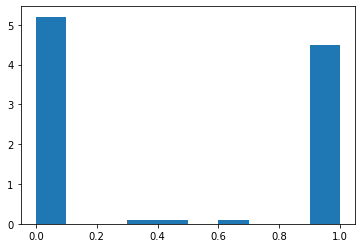

In [32]:
plt.hist(klvi_probs[1,:], bins=10, density=True, range=(0,1))
plt.show()

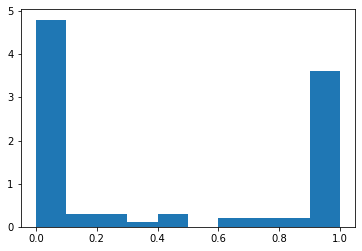

In [33]:
plt.hist(klvi_probs[10,:], bins=10, density=True, range=(0,1))
plt.show()

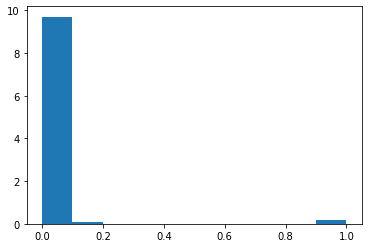

In [34]:
plt.hist(klvi_probs[D,:], bins=10, density=True, range=(0,1))
plt.show()

In [35]:
np.savetxt("./data/klvi_probs.csv", klvi_probs, delimiter=",")

## CHIVI Mean field with Gaussian

In [36]:
# init_mean = np.zeros(D+1)
# init_log_std = np.ones(D+1)
# init_var_param = np.concatenate([init_mean, init_log_std])
# n_iters = 2000

In [37]:
init_var_param = klvi_var_param.copy()
n_iters = 2000

In [38]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)
chivi_objective_and_grad = black_box_chivi(2, mf_gaussian_var_family, stan_log_density, 200)

chivi_var_param, chivi_param_history, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=5e-4)

Average Loss = -514.15: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.93it/s]


In [39]:
#plot_dist_to_opt_param(chivi_param_history, chivi_var_param)

In [40]:
check_approx_accuracy(mf_gaussian_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 0.00824444 -0.06341375 -0.08692164 -0.4711469   0.0408359   0.96892019
 -0.1134993   0.28292113  0.02553542  0.13229639  0.18948054  0.41025916
 -1.16355101  1.68552837]
stdevs = [0.03102788 0.02628284 0.07912794 0.13140763 0.05063549 0.04415807
 0.05794659 0.06954742 0.13370849 0.17556052 0.109305   0.14983842
 0.30170056 0.04462169]

mean error             = 2.61
stdev error            = 0.309
||cov error||_2^{1/2}  = 0.379
||true cov||_2^{1/2}   = 0.479


In [41]:
mc_samples=100000

In [42]:
chivi_samples, chivi_slw, chivi_lw, chivi_khat = \
    psis_correction(stan_log_density, mf_gaussian_var_family, chivi_var_param, mc_samples)

In [43]:
print(chivi_khat)

2.3987269307860872


In [44]:
chivi_slw

array([-109.29356004,  -38.34546479,  -46.30810456, ...,  -38.74881329,
        -25.23302412,  -21.64202785])

In [45]:
chivi_lw

array([-611.11284952, -540.16475427, -548.12739404, ..., -540.56810277,
       -527.0523136 , -523.46131733])

### VSBC diagnostics

In [46]:
M = 100
chivi_probs = np.zeros(shape=(D+1, M))
n_iters = 2000

#np.random.seed(123)
np.random.seed(100)

In [47]:
start = time.time()
for i in range(M):
    start_loop = time.time()
    
    # sample from prior    
    btemp = np.random.randn(1, D)
    mtemp = np.dot(x.values, np.transpose(btemp))
    stemp = np.random.gamma(.5, .5, 1)
    ytemp = mtemp + stemp
    
    datatemp = dict(N=N, D=D, x=x, y=y)
    fittemp = regression_model.sampling(data=datatemp, iter=20000, thin=20, chains=10)
    stan_log_density_temp = make_stan_log_density(fittemp)
    
    chivi_objective_and_grad_temp = black_box_chivi(2, mf_gaussian_var_family, stan_log_density_temp, 200)
    
    init_var_param = klvi_temp_var_param.copy()
    # run chivi
    chivi_temp_var_param, _, _, _ = \
        adagrad_optimize(n_iters, chivi_objective_and_grad_temp, init_var_param, learning_rate=5e-4)
    
    # store files for later
    chivi_samples_temp, chivi_slw_temp, chivi_lw_temp, chivi_khat_temp = \
        psis_correction(stan_log_density, mf_gaussian_var_family, chivi_var_param, mc_samples)
    
    with open("./data/chivi_psis_"+str(i)+".pkl", 'wb') as f:
        pickle.dump([btemp, stemp, chivi_samples_temp, chivi_slw_temp, chivi_lw_temp, chivi_khat_temp, chivi_var_param], f)
    
    
    ##################################################################
    ##################################################################
    # can remove this part and do it later with the pickled data file
    
    # extract beta mean and std
    b_mean_temp = chivi_temp_var_param[:D]
    b_std_temp = np.exp(chivi_temp_var_param[D+1:][0:D])
    
    # generate 1000 sample from the variational family
    nn = 1000
    sample_temp = mf_gaussian_var_family.sample(chivi_temp_var_param, nn)
    
    # compute log sigma of the samples
    logs_sample_temp = []
    for j in range(nn):
        logs_sample_temp.append(sample_temp[j][-1])
    logs_sample_temp = np.array(logs_sample_temp)
    logs_sample_temp = np.log(logs_sample_temp)
    
    # get the cdf values
    chivi_probs[0:D, i] = norm.cdf(btemp, b_mean_temp[0:D], b_std_temp[0:D])
    chivi_probs[D, i] = norm.cdf(np.log(stemp), np.mean(logs_sample_temp), np.std(logs_sample_temp))
    
    ##################################################################
    ##################################################################
    
    end_loop = time.time()
    print("Iteration = %i, loop time = %f, time elapsed = %f" % (i, end_loop-start_loop, end_loop-start))
    
end = time.time()
print("Total time taken: %f" % (end-start))

Average Loss = -512.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.58it/s]


Iteration = 0, loop time = 45.166456, time elapsed = 45.166456


Average Loss = -513.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.03it/s]


Iteration = 1, loop time = 42.367853, time elapsed = 87.535310


Average Loss = -514.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.26it/s]


Iteration = 2, loop time = 42.486507, time elapsed = 130.022818


Average Loss = -515.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.50it/s]


Iteration = 3, loop time = 42.160935, time elapsed = 172.184754


Average Loss = -512.93: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.43it/s]


Iteration = 4, loop time = 42.958746, time elapsed = 215.144501


Average Loss = -514.54: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.29it/s]


Iteration = 5, loop time = 41.885180, time elapsed = 257.030683


Average Loss = -512.04: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.30it/s]


Iteration = 6, loop time = 43.211497, time elapsed = 300.243181


Average Loss = -513.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.84it/s]


Iteration = 7, loop time = 42.367558, time elapsed = 342.611740


Average Loss = -512.62: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.92it/s]


Iteration = 8, loop time = 42.253779, time elapsed = 384.866520


Average Loss = -513.06: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.82it/s]


Iteration = 9, loop time = 41.931189, time elapsed = 426.798710


Average Loss = -512.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.69it/s]


Iteration = 10, loop time = 42.525543, time elapsed = 469.325256


Average Loss = -517.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.40it/s]


Iteration = 11, loop time = 41.779049, time elapsed = 511.105308


Average Loss = -512.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 75.13it/s]


Iteration = 12, loop time = 43.719697, time elapsed = 554.826005


Average Loss = -512.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.97it/s]


Iteration = 13, loop time = 41.737717, time elapsed = 596.564723


Average Loss = -511.93: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 81.06it/s]


Iteration = 14, loop time = 42.021272, time elapsed = 638.586996


Average Loss = -511.94: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.89it/s]


Iteration = 15, loop time = 42.245371, time elapsed = 680.833368


Average Loss = -512.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.05it/s]


Iteration = 16, loop time = 43.721057, time elapsed = 724.556427


Average Loss = -513.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.70it/s]


Iteration = 17, loop time = 43.289954, time elapsed = 767.846381


Average Loss = -516.03: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.13it/s]


Iteration = 18, loop time = 43.668423, time elapsed = 811.516806


Average Loss = -512.99: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.70it/s]


Iteration = 19, loop time = 43.513262, time elapsed = 855.032069


Average Loss = -512.43: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 75.52it/s]


Iteration = 20, loop time = 43.557671, time elapsed = 898.590741


Average Loss = -512.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.23it/s]


Iteration = 21, loop time = 43.485029, time elapsed = 942.076770


Average Loss = -512.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.79it/s]


Iteration = 22, loop time = 46.680119, time elapsed = 988.757889


Average Loss = -511.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.09it/s]


Iteration = 23, loop time = 42.609476, time elapsed = 1031.368366


Average Loss = -517.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.12it/s]


Iteration = 24, loop time = 43.426572, time elapsed = 1074.795939


Average Loss = -515.6: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.67it/s]


Iteration = 25, loop time = 43.652471, time elapsed = 1118.449411


Average Loss = -513.06: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.86it/s]


Iteration = 26, loop time = 41.673963, time elapsed = 1160.124374


Average Loss = -513.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.25it/s]


Iteration = 27, loop time = 43.759746, time elapsed = 1203.885121


Average Loss = -510.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.74it/s]


Iteration = 28, loop time = 42.722368, time elapsed = 1246.608490


Average Loss = -514.48: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.44it/s]


Iteration = 29, loop time = 42.876642, time elapsed = 1289.486133


Average Loss = -517.02: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.94it/s]


Iteration = 30, loop time = 45.690988, time elapsed = 1335.178122


Average Loss = -515.7: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.63it/s]


Iteration = 31, loop time = 43.610488, time elapsed = 1378.789612


Average Loss = -512.07: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.68it/s]


Iteration = 32, loop time = 43.450271, time elapsed = 1422.240884


Average Loss = -514.26: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.42it/s]


Iteration = 33, loop time = 43.729507, time elapsed = 1465.971392


Average Loss = -513.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.19it/s]


Iteration = 34, loop time = 43.715810, time elapsed = 1509.688203


Average Loss = -512.57: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.30it/s]


Iteration = 35, loop time = 44.800804, time elapsed = 1554.490008


Average Loss = -512.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.85it/s]


Iteration = 36, loop time = 43.420275, time elapsed = 1597.911285


Average Loss = -512.67: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.00it/s]


Iteration = 37, loop time = 45.240081, time elapsed = 1643.152367


Average Loss = -513.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.37it/s]


Iteration = 38, loop time = 43.331223, time elapsed = 1686.484591


Average Loss = -512.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.29it/s]


Iteration = 39, loop time = 42.563303, time elapsed = 1729.048895


Average Loss = -513.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.12it/s]


Iteration = 40, loop time = 43.949668, time elapsed = 1772.999564


Average Loss = -513.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.28it/s]


Iteration = 41, loop time = 42.812992, time elapsed = 1815.813557


Average Loss = -513.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.93it/s]


Iteration = 42, loop time = 43.821599, time elapsed = 1859.637159


Average Loss = -514.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.92it/s]


Iteration = 43, loop time = 44.135743, time elapsed = 1903.773903


Average Loss = -512.97: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.31it/s]


Iteration = 44, loop time = 43.933751, time elapsed = 1947.708655


Average Loss = -512.31: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.73it/s]


Iteration = 45, loop time = 43.439564, time elapsed = 1991.149220


Average Loss = -512.67: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.80it/s]


Iteration = 46, loop time = 43.866310, time elapsed = 2035.016530


Average Loss = -516.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.06it/s]


Iteration = 47, loop time = 44.466837, time elapsed = 2079.484368


Average Loss = -513.82: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.84it/s]


Iteration = 48, loop time = 43.028808, time elapsed = 2122.514177


Average Loss = -512.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 76.92it/s]


Iteration = 49, loop time = 43.157145, time elapsed = 2165.672323


Average Loss = -512.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.42it/s]


Iteration = 50, loop time = 43.501521, time elapsed = 2209.174845


Average Loss = -514.94: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.55it/s]


Iteration = 51, loop time = 42.942701, time elapsed = 2252.118547


Average Loss = -514.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.09it/s]


Iteration = 52, loop time = 43.270614, time elapsed = 2295.390162


Average Loss = -513.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 73.73it/s]


Iteration = 53, loop time = 44.307855, time elapsed = 2339.699019


Average Loss = -516.81: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.26it/s]


Iteration = 54, loop time = 44.391687, time elapsed = 2384.091706


Average Loss = -514.42: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.46it/s]


Iteration = 55, loop time = 43.368144, time elapsed = 2427.460851


Average Loss = -514.93: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.69it/s]


Iteration = 56, loop time = 45.091977, time elapsed = 2472.553829


Average Loss = -512.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.65it/s]


Iteration = 57, loop time = 47.624029, time elapsed = 2520.178859


Average Loss = -513.57: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 67.12it/s]


Iteration = 58, loop time = 49.934479, time elapsed = 2570.115340


Average Loss = -515.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 66.72it/s]


Iteration = 59, loop time = 49.123415, time elapsed = 2619.239756


Average Loss = -513.99: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.89it/s]


Iteration = 60, loop time = 44.467122, time elapsed = 2663.707879


Average Loss = -512.32: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 78.28it/s]


Iteration = 61, loop time = 43.917999, time elapsed = 2707.626880


Average Loss = -512.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.65it/s]


Iteration = 62, loop time = 44.964952, time elapsed = 2752.592833


Average Loss = -512.56: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.50it/s]


Iteration = 63, loop time = 46.584429, time elapsed = 2799.178262


Average Loss = -511.75: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.60it/s]


Iteration = 64, loop time = 45.740659, time elapsed = 2844.919922


Average Loss = -512.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.61it/s]


Iteration = 65, loop time = 46.020916, time elapsed = 2890.941839


Average Loss = -512.9: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.20it/s]


Iteration = 66, loop time = 47.680425, time elapsed = 2938.623264


Average Loss = -514.38: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.31it/s]


Iteration = 67, loop time = 49.030386, time elapsed = 2987.655653


Average Loss = -513.08: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.43it/s]


Iteration = 68, loop time = 46.159040, time elapsed = 3033.815692


Average Loss = -513.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.13it/s]


Iteration = 69, loop time = 48.654857, time elapsed = 3082.471550


Average Loss = -513.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.72it/s]


Iteration = 70, loop time = 42.314538, time elapsed = 3124.787091


Average Loss = -514.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.87it/s]


Iteration = 71, loop time = 43.801893, time elapsed = 3168.589984


Average Loss = -513.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.66it/s]


Iteration = 72, loop time = 43.121247, time elapsed = 3211.712232


Average Loss = -513.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.01it/s]


Iteration = 73, loop time = 42.787779, time elapsed = 3254.501011


Average Loss = -512.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.05it/s]


Iteration = 74, loop time = 42.965599, time elapsed = 3297.467611


Average Loss = -512.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.97it/s]


Iteration = 75, loop time = 41.973831, time elapsed = 3339.442443


Average Loss = -516.97: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.86it/s]


Iteration = 76, loop time = 41.193616, time elapsed = 3380.637061


Average Loss = -513.5: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.73it/s]


Iteration = 77, loop time = 41.100249, time elapsed = 3421.738311


Average Loss = -511.57: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.44it/s]


Iteration = 78, loop time = 41.404572, time elapsed = 3463.144885


Average Loss = -513.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.71it/s]


Iteration = 79, loop time = 42.340955, time elapsed = 3505.486841


Average Loss = -512.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 76.70it/s]


Iteration = 80, loop time = 41.870135, time elapsed = 3547.357977


Average Loss = -513.84: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 80.75it/s]


Iteration = 81, loop time = 43.994450, time elapsed = 3591.353428


Average Loss = -511.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 78.07it/s]


Iteration = 82, loop time = 42.723769, time elapsed = 3634.078197


Average Loss = -512.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 74.07it/s]


Iteration = 83, loop time = 43.858192, time elapsed = 3677.937390


Average Loss = -512.14: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.01it/s]


Iteration = 84, loop time = 43.225145, time elapsed = 3721.163536


Average Loss = -514.93: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.56it/s]


Iteration = 85, loop time = 42.790969, time elapsed = 3763.955507


Average Loss = -513.58: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.67it/s]


Iteration = 86, loop time = 43.315858, time elapsed = 3807.272365


Average Loss = -513.1: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.20it/s]


Iteration = 87, loop time = 41.457919, time elapsed = 3848.731285


Average Loss = -513.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.47it/s]


Iteration = 88, loop time = 46.295439, time elapsed = 3895.027724


Average Loss = -513.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.30it/s]


Iteration = 89, loop time = 45.639803, time elapsed = 3940.669529


Average Loss = -512.6: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.85it/s]


Iteration = 90, loop time = 45.826645, time elapsed = 3986.497176


Average Loss = -513.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.27it/s]


Iteration = 91, loop time = 45.609782, time elapsed = 4032.107954


Average Loss = -512.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.79it/s]


Iteration = 92, loop time = 45.850980, time elapsed = 4077.959935


Average Loss = -512.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.85it/s]


Iteration = 93, loop time = 43.684808, time elapsed = 4121.645744


Average Loss = -513.42: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.64it/s]


Iteration = 94, loop time = 44.089048, time elapsed = 4165.735794


Average Loss = -512.68: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.30it/s]


Iteration = 95, loop time = 44.819279, time elapsed = 4210.556074


Average Loss = -519.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.50it/s]


Iteration = 96, loop time = 43.950258, time elapsed = 4254.507333


Average Loss = -512.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.42it/s]


Iteration = 97, loop time = 45.629514, time elapsed = 4300.137848


Average Loss = -513.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.76it/s]


Iteration = 98, loop time = 46.014741, time elapsed = 4346.153590


Average Loss = -512.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.97it/s]


Iteration = 99, loop time = 46.462904, time elapsed = 4392.617496
Total time taken: 4392.618496


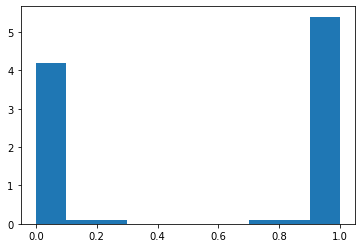

In [48]:
plt.hist(chivi_probs[1,:], bins=10, density=True, range=(0,1))
plt.show()

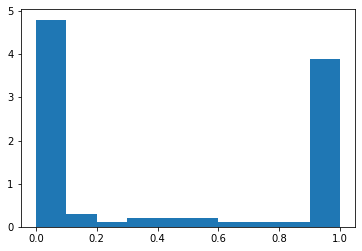

In [49]:
plt.hist(chivi_probs[10,:], bins=10, density=True, range=(0,1))
plt.show()

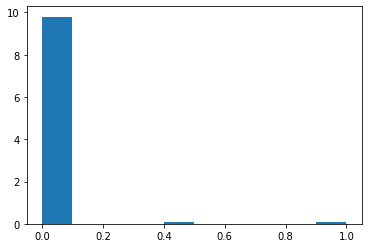

In [50]:
plt.hist(chivi_probs[D,:], bins=10, density=True, range=(0,1))
plt.show()

In [51]:
np.savetxt("./data/chivi_probs.csv", chivi_probs, delimiter=",")

# Misc: testing other algorithms

## KLVI Non-mean field full-rank 

In [52]:
t_var_family = t_variational_family(D+1, 100)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)

full_klvi_var_param, full_klvi_param_history, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

Average Loss = 529.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 154.78it/s]


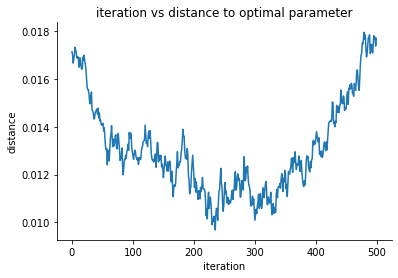

In [53]:
plot_dist_to_opt_param(full_klvi_param_history, full_klvi_var_param)

In [54]:
full_klvi_samples, full_klvi_slw, full_klvi_lw, full_klvi_khat = \
    psis_correction(stan_log_density, t_var_family, full_klvi_var_param, mc_samples)

In [55]:
print(full_klvi_khat)

0.10758885550987357


In [56]:
full_klvi_slw

array([-11.18323412, -11.31687864, -11.46977969, ..., -11.53162536,
       -11.62182747, -11.61838622])

In [57]:
full_klvi_lw

array([-508.98821301, -509.12185754, -509.27475859, ..., -509.33660426,
       -509.42680637, -509.42336512])

## KLVI Mean field with t distribution (df=40)

In [58]:
# mf_t_var_family = mean_field_t_variational_family(D+1, 40)
# klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

# klvi_t_var_param, klvi_t_param_history, klvi_t_history, _ = \
#     adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

In [59]:
#plot_dist_to_opt_param(klvi_t_param_history, klvi_t_var_param)

In [60]:
#check_approx_accuracy(mf_t_var_family, klvi_t_var_param, true_mean, true_cov, verbose=True);

In [61]:
#klvi_t_samples, klvi_t_slw, klvi_t_khat = \
#    psis_correction(stan_log_density, mf_t_var_family, klvi_t_var_param, mc_samples)

In [62]:
#print(klvi_t_khat)

In [63]:
#klvi_t_slw

## CHIVI Mean field with t distribution (df=40)

In [64]:
# mf_t_var_family = mean_field_t_variational_family(D+1, 40)
# chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 400)

# init_var_param = klvi_var_param.copy()
# init_var_param[2:] += 3

# chivi_t_var_param, chivi_t_param_history, chivi_t_history, _ = \
#     adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

In [65]:
# plot_dist_to_opt_param(chivi_t_param_history, chivi_t_var_param)

In [66]:
# chivi_t_samples, chivi_t_slw, chivi_t_khat = \
#     psis_correction(stan_log_density, mf_t_var_family, chivi_t_var_param, mc_samples)

In [67]:
# print(chivi_t_khat)

In [68]:
# chivi_t_slw

### CHIVI full rank

In [69]:
# t_var_family = t_variational_family(D+1, 100)
# full_chivi_objective_and_grad = black_box_chivi(2, t_var_family, stan_log_density, 400)

# init_var_param = full_klvi_var_param.copy()
# init_var_param[2:] += 3

# full_chivi_var_param, full_chivi_param_history, full_chivi_history, _ = \
#     adagrad_optimize(n_iters, full_chivi_objective_and_grad, init_var_param, 
#                      learning_rate=.1, learning_rate_end=.001)

In [70]:
#plot_dist_to_opt_param(full_chivi_param_history, full_chivi_var_param)

In [71]:
#full_chivi_samples, full_chivi_slw, full_chivi_khat = \
#    psis_correction(stan_log_density, t_var_family, full_chivi_var_param, mc_samples)

In [72]:
#print(full_chivi_khat)

In [73]:
#full_chivi_slw